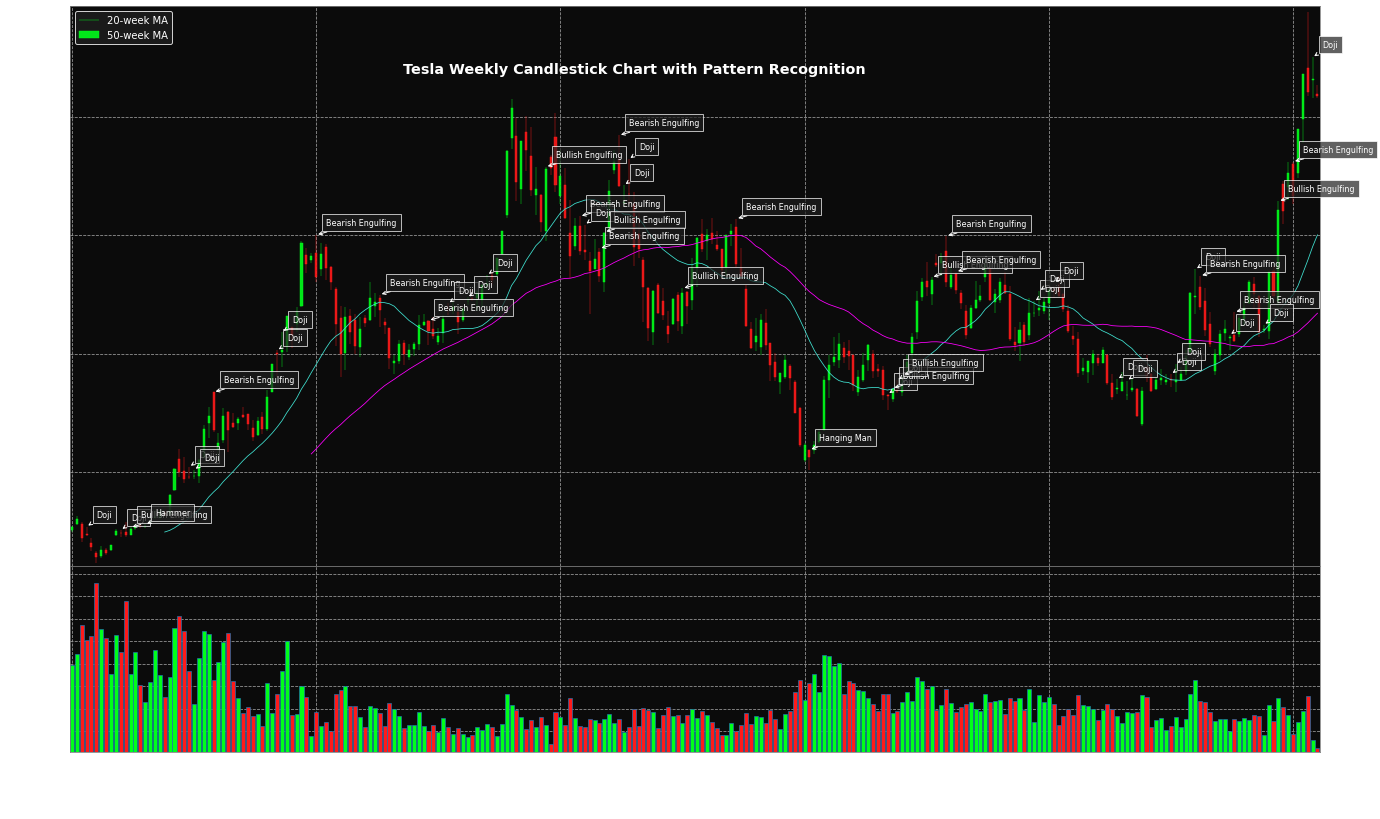

In [1]:
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
import numpy as np

# Load and prepare data
df = pd.read_csv('INFO6105_Final_TSLA_FeatureMart (1).xls')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

def detect_patterns(df):
    """Detect candlestick patterns"""
    patterns = pd.DataFrame(index=df.index, columns=['Pattern'])
    
    for i in range(1, len(df)):
        # Doji pattern
        body = abs(df['Close'][i] - df['Open'][i])
        wick = df['High'][i] - df['Low'][i]
        if body <= 0.1 * wick:
            patterns['Pattern'][i] = 'Doji'
            
        # Hammer pattern
        body = df['Close'][i] - df['Open'][i]
        upper_wick = df['High'][i] - max(df['Open'][i], df['Close'][i])
        lower_wick = min(df['Open'][i], df['Close'][i]) - df['Low'][i]
        if lower_wick > 2 * abs(body) and upper_wick <= abs(body) * 0.1:
            patterns['Pattern'][i] = 'Hammer'
            
        # Hanging Man
        if upper_wick <= abs(body) * 0.1 and lower_wick > 2 * abs(body) and body < 0:
            patterns['Pattern'][i] = 'Hanging Man'
            
        # Bullish Engulfing
        if (df['Close'][i-1] < df['Open'][i-1] and 
            df['Close'][i] > df['Open'][i] and 
            df['Close'][i] > df['Open'][i-1] and 
            df['Open'][i] < df['Close'][i-1]):
            patterns['Pattern'][i] = 'Bullish Engulfing'
            
        # Bearish Engulfing
        if (df['Close'][i-1] > df['Open'][i-1] and 
            df['Close'][i] < df['Open'][i] and 
            df['Close'][i] < df['Open'][i-1] and 
            df['Open'][i] > df['Close'][i-1]):
            patterns['Pattern'][i] = 'Bearish Engulfing'
    
    return patterns

# Create OHLCV dataframe with patterns
ohlcv = pd.DataFrame({
    'Open': df['open'],
    'High': df['high'],
    'Low': df['low'],
    'Close': df['close'],
    'Volume': df['volume']
})

# Resample to weekly and detect patterns
weekly_data = ohlcv.resample('W').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}).dropna()

patterns = detect_patterns(weekly_data)

# Enhanced dark style
mc = mpf.make_marketcolors(
    up='#00ff1a',          # Bright green for up days
    down='#ff1a1a',        # Bright red for down days
    edge='inherit',
    wick='inherit',
    volume='in',
    ohlc='inherit'
)

style = mpf.make_mpf_style(
    base_mpf_style='nightclouds',
    marketcolors=mc,
    gridstyle='--',
    rc={
        'figure.facecolor': '#1e1e1e',
        'axes.facecolor': '#1e1e1e',
        'axes.edgecolor': '#808080',
        'axes.labelcolor': 'white',
        'xtick.color': 'white',
        'ytick.color': 'white',
        'text.color': 'white'
    }
)

# Create figure and axis
fig, axes = mpf.plot(
    weekly_data,
    type='candle',
    style=style,
    title='Tesla Weekly Candlestick Chart with Pattern Recognition',
    ylabel='Price ($)',
    ylabel_lower='Volume',
    volume=True,
    figsize=(20, 12),
    panel_ratios=(3, 1),
    mav=(20, 50),  # 20 and 50-week moving averages
    tight_layout=True,
    returnfig=True
)

# Add pattern labels
ax = axes[0]
for idx, pattern in patterns[patterns['Pattern'].notna()].iterrows():
    ax.annotate(
        pattern['Pattern'],
        xy=(weekly_data.index.get_loc(idx), weekly_data['High'][idx]),
        xytext=(10, 10),
        textcoords='offset points',
        color='white',
        fontsize=8,
        bbox=dict(facecolor='#1e1e1e', edgecolor='white', alpha=0.7),
        arrowprops=dict(arrowstyle='->', color='white')
    )

# Add legend for moving averages
ax.legend(['20-week MA', '50-week MA'], 
         loc='upper left', 
         facecolor='#1e1e1e', 
         edgecolor='white', 
         labelcolor='white')

plt.show()

## Correlation analysis excluding future looking indicators

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Load and prepare data
df = pd.read_csv('INFO6105_Final_TSLA_FeatureMart (1).xls')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Target variable
price_type = 'close'
y = df[price_type]

# Remove price-related, future-looking, and target-derived columns
exclude_columns = [
    'Return_1D', 'Return_5D', 'Return_1M',  # Future returns
    'close', 'high', 'low', 'open',         # Price data
    'Lag_Close_1', 'Lag_Close_5', 'Lag_Close_10',  # Lagged prices
    'Unnamed: 0',
    'BBU_10_2.0', 'BBL_10_2.0', 'BBM_10_2.0',  # Forward-looking indicators
    'BBB_10_2.0', 'BBP_10_2.0',
    'MACDh_5_20_9', 'MACD_5_20_9'  # MACD can include future data
]

# Create features
features = df.drop([col for col in exclude_columns if col in df.columns], axis=1)
features = features.fillna(method='ffill').fillna(method='bfill')

# Clean data
mask = ~(features.isna().any(axis=1) | y.isna())
X = features[mask]
y = y[mask]

# Calculate correlations
correlations = X.corrwith(y)
abs_correlations = correlations.abs()

# Fit model
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Calculate metrics
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
pred_corr = np.corrcoef(y, y_pred)[0,1]

# Calculate significant features
significant_features = sum(1 for column in X.columns
                         if stats.linregress(X[column], y)[3] <= 0.05)


print("\nCorrelation Metrics:")
print("-" * 50)
print(f"Mean Correlation: {correlations.mean():.4f}")
print(f"Mean Absolute Correlation: {abs_correlations.mean():.4f}")
print(f"Max Absolute Correlation: {abs_correlations.max():.4f}")

print("\nModel Performance:")
print("-" * 50)
print(f"R-squared: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"Prediction Correlation: {pred_corr:.4f}")
print(f"Significant Features (p ≤ 0.05): {significant_features}")


Correlation Metrics:
--------------------------------------------------
Mean Correlation: 0.2040
Mean Absolute Correlation: 0.3172
Max Absolute Correlation: 0.9819

Model Performance:
--------------------------------------------------
R-squared: 0.9913
RMSE: 7.3836
MSE: 54.5173
Prediction Correlation: 0.9957
Significant Features (p ≤ 0.05): 28


Best of the Feature Mart:

1) log_return: Captures daily percentage changes in Tesla's closing price, which is the target variable for regression.

2) volatility: Measures the 20-day rolling standard deviation of log returns, representing price variability and market risk.

3) log_volume: Represents the logarithm of trading volume, capturing the scale of market activity.

4) rsi: Relative Strength Index, identifies overbought or oversold conditions, aiding in momentum analysis.

5) bb_width: Bollinger Band Width, measures market volatility by capturing the width of Bollinger Bands.

6) atr: Average True Range, captures the average price range over time, representing market volatility.

7) vix_ratio: Ratio of the VIX (volatility index) to its 10-day moving average, reflecting market-wide fear or complacency.

8) sp500_return: Log returns of the S&P 500 index, capturing Tesla's sensitivity to overall market movements.

9) price_volume: Interaction term between log returns and volume moving average ratio, combining price momentum and trading activity.

10) rsi_vix: Interaction term between RSI and VIX, combining momentum and market sentiment.

11) volume_ma_ratio: Ratio of current volume to its 20-day moving average, highlighting deviations from normal trading activity.

## Rolling Regression Analysis with HAC Standard Errors

1) The rolling regression model uses a 252-day window (one trading year) to capture time-varying relationships in Tesla's stock returns. By moving this window through time, we account for evolving market conditions and changing relationships between features. 

2) Heteroskedasticity and Autocorrelation Consistent (HAC) standard errors are implemented to handle two key characteristics of financial time series: varying volatility (heteroskedasticity) and serial correlation in returns (autocorrelation). 

3) Using cov_type='HAC' with Newey-West lags of 5 days makes our model more robust by accounting for these statistical properties, resulting in more reliable coefficient estimates and hypothesis tests.

R-squared: 0.9054
MSE: 0.000135
R-squared Stability (std): 0.0275


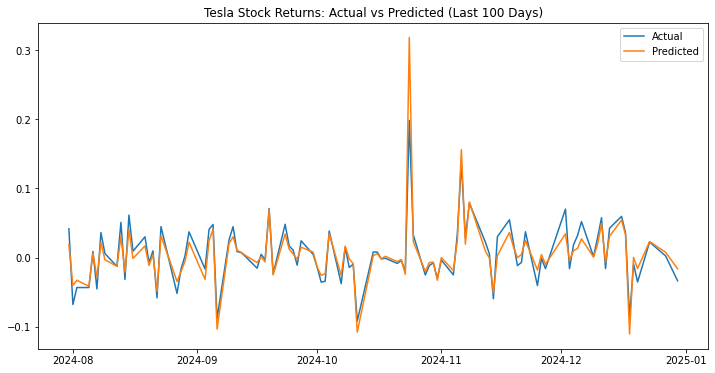


Final Model Summary:
                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     291.3
Date:                Wed, 26 Mar 2025   Prob (F-statistic):          1.05e-309
Time:                        12:01:47   Log-Likelihood:                 3386.7
No. Observations:                1186   AIC:                            -6751.
Df Residuals:                    1175   BIC:                            -6696.
Df Model:                          10                                         
Covariance Type:                  HAC                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               

In [6]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import ta
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
warnings.filterwarnings('ignore')

def create_refined_features(df):
    df = df.copy()
    
    # Price-based features
    df['log_return'] = np.log(df['close']).diff()
    df['volatility'] = df['log_return'].rolling(window=20).std()
    
    # Volume features 
    df['log_volume'] = np.log(df['volume'])
    df['volume_ma_ratio'] = df['volume'] / df['volume'].rolling(20).mean()
    
    # Technical indicators
    df['rsi'] = ta.momentum.rsi(df['close'], window=14)
    df['bb_width'] = ta.volatility.bollinger_wband(df['close'])
    df['atr'] = ta.volatility.average_true_range(df['high'], df['low'], df['close'])
    
    # Market features
    df['vix_ratio'] = df['VIXCLS'] / df['VIXCLS'].rolling(10).mean()
    df['sp500_return'] = np.log(df['SP500']).diff()
    
    # Interaction terms
    df['price_volume'] = df['log_return'] * df['volume_ma_ratio']
    df['rsi_vix'] = df['rsi'] / df['VIXCLS']
    
    return df

def rolling_regression(X, y, window=252):
    predictions = []
    coefficients = []
    r2_values = []
    
    # Create Newey-West HAC covariance matrix
    for i in range(window, len(X)):
        # Training data
        X_train = X[i-window:i]
        y_train = y[i-window:i]
        
        # Test data (next day)
        X_test = X[i:i+1]
        
        # Add constant
        X_train_const = sm.add_constant(X_train)
        X_test_const = sm.add_constant(X_test, has_constant='add')
        
        # Fit model with HAC standard errors
        model = sm.OLS(y_train, X_train_const).fit(
            cov_type='HAC',
            cov_kwds={'maxlags': int(np.floor(4 * (window/100)**(2/9)))  # Newey-West optimal lag selection
        })
        
        # Predict
        pred = model.predict(X_test_const)
        predictions.append(pred[0])
        coefficients.append(model.params)
        r2_values.append(model.rsquared)
        
    return np.array(predictions), coefficients, r2_values

# Load data
df = pd.read_csv('INFO6105_Final_TSLA_FeatureMart (1).xls')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Create features
df = create_refined_features(df)

# Select features
features = [
    'log_volume',
    'volume_ma_ratio', 
    'rsi',
    'bb_width',
    'atr',
    'vix_ratio',
    'sp500_return',
    'price_volume',
    'rsi_vix',
    'volatility'
]

# Prepare data
X = df[features].copy()
y = df['log_return']

# Handle missing values
X = X.fillna(method='ffill').fillna(method='bfill')
y = y.fillna(method='ffill')

# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index
)

# Remove any remaining NaN
mask = ~(X_scaled.isna().any(axis=1) | y.isna())
X_clean = X_scaled[mask]
y_clean = y[mask]

# Implement rolling regression
predictions, coefficients, r2_values = rolling_regression(X_clean, y_clean)

# Calculate performance metrics
actual_values = y_clean[-len(predictions):]
r2 = r2_score(actual_values, predictions)
mse = mean_squared_error(actual_values, predictions)

# Add R-squared stability metric
r2_stability = np.std(r2_values)
print(f"R-squared: {r2:.4f}")
print(f"MSE: {mse:.6f}")
print(f"R-squared Stability (std): {r2_stability:.4f}")

# Plot results
plt.figure(figsize=(12,6))
plt.plot(actual_values.index[-100:], actual_values[-100:], label='Actual')
plt.plot(actual_values.index[-100:], predictions[-100:], label='Predicted')
plt.title('Tesla Stock Returns: Actual vs Predicted (Last 100 Days)')
plt.legend()
plt.show()

# Final full-sample model for analysis
final_model = sm.OLS(y_clean, sm.add_constant(X_clean)).fit(
    cov_type='HAC',
    cov_kwds={'maxlags': 5}
)
print("\nFinal Model Summary:")
print(final_model.summary())

## PCA COMPETITOR MODEL 

For competitor analysis, we track EV makers (NIO, RIVN, LCID, LI, XPEV) to capture direct competition in the electric vehicle space, traditional automakers (GM, F, TM, VWAGY, BMW.DE) for broader automotive industry trends, tech giants (AAPL, NVDA, AMD) due to Tesla's significant tech component, and relevant ETFs (XLY, ARKK, DRIV) for sector-wide movements. 

These are complemented by technical indicators including RSI (overbought/oversold conditions), Bollinger Bands (volatility trends), and ATR (price range analysis). Market sentiment is captured through VIX ratios and S&P500 momentum, while volume analysis uses volume ratios and dollar volume impact.



Enhanced PCA Model with Maximized R² Score
--------------------------------------------------

Model Performance Metrics:
--------------------------------------------------
R-squared: 0.8268
Adjusted R-squared: 0.8207
Number of observations: 1186.0
Number of features: 41

PCA Components Explanation:
Variance explained: 0.9906
Number of components used: 10


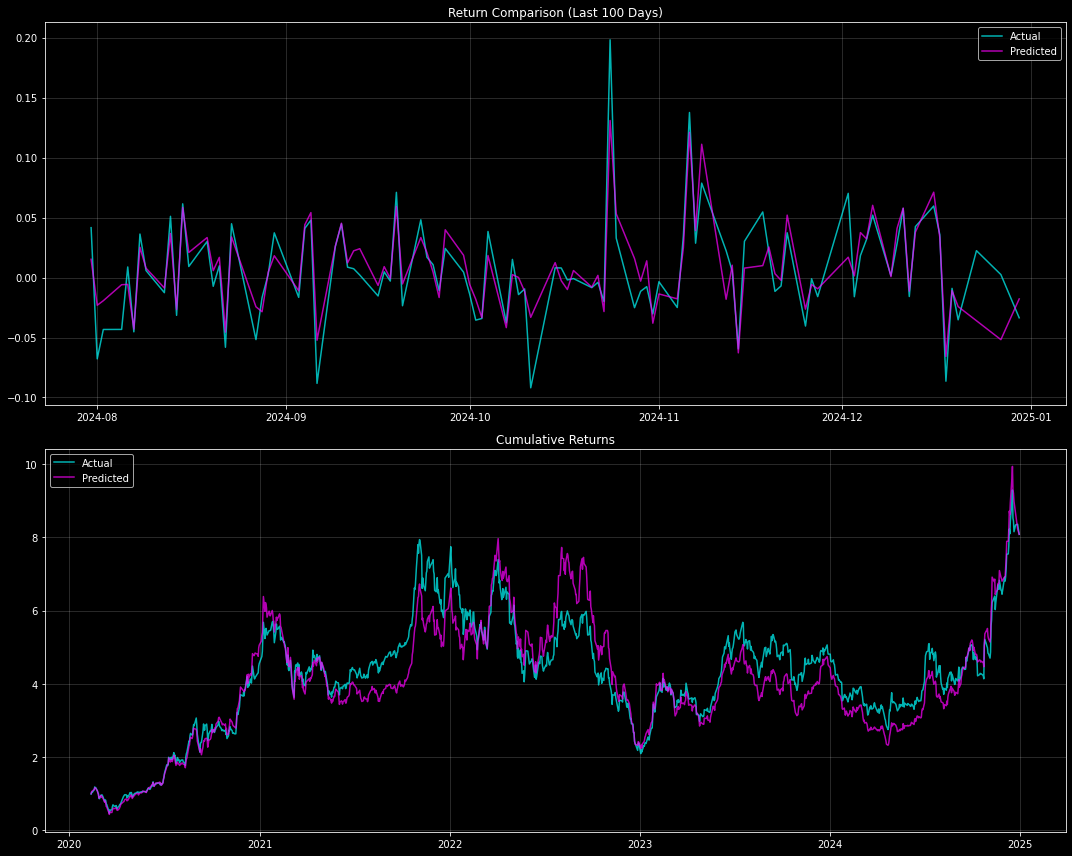

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

def create_advanced_features(df):
    """Create advanced technical and market features"""
    # Price-based features
    df['log_return'] = np.log(df['close']).diff()
    df['high_low_ratio'] = df['high'] / df['low']
    df['close_open_ratio'] = df['close'] / df['open']
    
    # Volume features
    df['volume_ma'] = df['volume'].rolling(window=20).mean()
    df['volume_ratio'] = df['volume'] / df['volume_ma']
    df['dollar_volume'] = df['close'] * df['volume']
    
    # Technical indicators
    df['rsi'] = ta.momentum.rsi(df['close'], window=14)
    df['rsi_30'] = ta.momentum.rsi(df['close'], window=30)
    df['macd'] = ta.trend.macd_diff(df['close'])
    df['bb_width'] = ta.volatility.bollinger_wband(df['close'])
    df['atr'] = ta.volatility.average_true_range(df['high'], df['low'], df['close'])
    df['adx'] = ta.trend.adx(df['high'], df['low'], df['close'])
    df['cci'] = ta.trend.cci(df['high'], df['low'], df['close'])
    
    # Trend indicators
    df['sma_20'] = df['close'].rolling(window=20).mean()
    df['sma_50'] = df['close'].rolling(window=50).mean()
    df['trend_strength'] = (df['sma_20'] - df['sma_50']) / df['sma_50']
    
    # Market features
    df['vix_ratio'] = df['VIXCLS'] / df['VIXCLS'].rolling(10).mean()
    df['sp500_return'] = np.log(df['SP500']).diff()
    
    # Volatility features
    for window in [5, 10, 20, 30]:
        df[f'volatility_{window}'] = df['log_return'].rolling(window).std()
        df[f'momentum_{window}'] = df['log_return'].rolling(window).sum()
    
    return df

def maximize_pca_model(df):
    """Enhanced PCA model with optimized performance"""
    print("\nEnhanced PCA Model with Maximized R² Score")
    print("-" * 50)
    
    # Create advanced features
    df = create_advanced_features(df)
    
    # Load competitor data
    competitor_returns = pd.read_csv('tesla_competitors.csv', index_col=0)
    competitor_returns.index = pd.to_datetime(competitor_returns.index)
    
    # Prepare features and target
    y = df['log_return'].copy()
    features = df.drop(['open', 'high', 'low', 'close', 'volume', 'log_return'], axis=1)
    
    # Merge with competitor returns
    features = pd.concat([features, competitor_returns], axis=1)
    
    # Clean and prepare data
    features = features.replace([np.inf, -np.inf], np.nan)
    features = features.fillna(method='ffill').fillna(method='bfill')
    
    # Remove low variance features
    variance_threshold = 1e-6
    features = features.loc[:, features.std() > variance_threshold]
    
    # Scale features
    scaler = RobustScaler()  # More robust to outliers
    X_scaled = scaler.fit_transform(features)
    
    # Apply PCA
    pca = PCA(n_components=0.99)  # Capture 99% of variance
    pca_features = pca.fit_transform(X_scaled)
    
    # Create PCA DataFrame
    X_pca = pd.DataFrame(
        pca_features,
        columns=[f'PC{i+1}' for i in range(pca_features.shape[1])],
        index=features.index
    )
    
    # Add non-linear transformations
    n_components = min(10, X_pca.shape[1])
    for i in range(n_components):
        if i < 5:  # Cubic terms for top 5 components
            X_pca[f'PC{i+1}_cubic'] = X_pca[f'PC{i+1}'] ** 3
        X_pca[f'PC{i+1}_squared'] = X_pca[f'PC{i+1}'] ** 2
    
    # Add interaction terms for top components
    for i in range(min(5, n_components)):
        for j in range(i+1, min(5, n_components)):
            X_pca[f'PC{i+1}_PC{j+1}'] = X_pca[f'PC{i+1}'] * X_pca[f'PC{j+1}']
    
    # Ensure data alignment
    common_idx = y.index.intersection(X_pca.index)
    y = y.loc[common_idx]
    X_pca = X_pca.loc[common_idx]
    
    # Sort by date
    y = y.sort_index()
    X_pca = X_pca.sort_index()
    
    # Remove any remaining NaN values
    mask = ~(y.isna() | X_pca.isna().any(axis=1))
    y = y[mask]
    X_pca = X_pca[mask]
    
    # Fit model
    X_with_const = sm.add_constant(X_pca)
    model = sm.OLS(y, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 5})
    predictions = model.predict(X_with_const)
    
    # Print detailed results
    print("\nModel Performance Metrics:")
    print("-" * 50)
    print(f"R-squared: {model.rsquared:.4f}")
    print(f"Adjusted R-squared: {model.rsquared_adj:.4f}")
    print(f"Number of observations: {model.nobs}")
    print(f"Number of features: {X_with_const.shape[1]}")
    print("\nPCA Components Explanation:")
    print(f"Variance explained: {pca.explained_variance_ratio_.sum():.4f}")
    print(f"Number of components used: {n_components}")
    
    # Visualization
    plt.style.use('dark_background')
    fig, axes = plt.subplots(2, 1, figsize=(15, 12))
    
    # Returns comparison
    axes[0].plot(y.index[-100:], y[-100:], label='Actual', color='cyan', alpha=0.7)
    axes[0].plot(y.index[-100:], predictions[-100:], label='Predicted', color='magenta', alpha=0.7)
    axes[0].set_title('Return Comparison (Last 100 Days)', fontsize=12)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.2)
    
    # Cumulative returns
    cum_actual = np.exp(y.cumsum())
    cum_pred = np.exp(predictions.cumsum())
    axes[1].plot(y.index, cum_actual, label='Actual', color='cyan', alpha=0.7)
    axes[1].plot(y.index, cum_pred, label='Predicted', color='magenta', alpha=0.7)
    axes[1].set_title('Cumulative Returns', fontsize=12)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.2)
    
    plt.tight_layout()
    plt.show()
    
    return model, predictions, y, pca.explained_variance_ratio_

# Execute the model
df = pd.read_csv('INFO6105_Final_TSLA_FeatureMart (1).xls')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

model, predictions, y, explained_var = maximize_pca_model(df)

## Stacked Regression Model 
we're using a Stacked Regression model that combines three powerful algorithms:

Lasso Regression: Handles linear relationships and performs feature selection
XGBoost (Base): Captures complex non-linear patterns in Tesla's price movements
XGBoost (Meta): Combines predictions from Lasso and base XGBoost

1) Tesla's stock moves on both traditional metrics (captured by Lasso) and non-linear factors like social media sentiment and news (captured by XGBoost)

2) The stacking architecture helps reduce overfitting, crucial for Tesla's volatile price movements

3) Lasso helps identify truly important features while XGBoost captures complex interactions

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

# Load and prepare data
df = pd.read_csv('INFO6105_Final_TSLA_FeatureMart (1).xls')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Remove target-derived and future-looking features
exclude_columns = ['Return_1D', 'Return_5D', 'Return_1M', 'Lag_Close_1', 
                  'Lag_Close_5', 'Lag_Close_10', 'Unnamed: 0']

# Prepare features and target
y = df['Return_1D']  # Target variable
X = df.drop([col for col in exclude_columns if col in df.columns], axis=1)

# Clean data
X = X.fillna(method='ffill').fillna(method='bfill')
mask = ~(X.isna().any(axis=1) | y.isna())
X = X[mask]
y = y[mask]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, shuffle=False
)

# Define models
lasso = Lasso(alpha=0.0001, max_iter=10000)
xgb_base = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.1,
    reg_lambda=1.2,
    random_state=42,
    n_jobs=-1
)
xgb_meta = XGBRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

# Create stacked model
stacked_model = StackingRegressor(
    estimators=[('lasso', lasso), ('xgb', xgb_base)],
    final_estimator=xgb_meta,
    n_jobs=-1
)

# Train model
stacked_model.fit(X_train, y_train)

# Make predictions
y_pred = stacked_model.predict(X_test)

# Calculate metrics
r2 = r2_score(y_test, y_pred)
n = X_test.shape[0]
p = X_test.shape[1]
adj_r2 = 1 - (1-r2)*(n-1)/(n-p-1)
pred_corr = np.corrcoef(y_test, y_pred)[0,1]

# Print results
print("\nStacked Model Performance Metrics:")
print("-" * 50)
print(f"R-squared: {r2:.4f}")
print(f"Adjusted R-squared: {adj_r2:.4f}")
print(f"Prediction Correlation: {pred_corr:.4f}")
print(f"\nModel Components:")
print("-" * 50)
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")


Stacked Model Performance Metrics:
--------------------------------------------------
R-squared: 0.6597
Adjusted R-squared: 0.5778
Prediction Correlation: 0.8484

Model Components:
--------------------------------------------------
Training samples: 949
Testing samples: 238
Number of features: 46


## Gradient boosting regression model 

This model uses Gradient Boosting Regression, an ensemble learning technique that builds multiple decision trees sequentially, where each tree tries to correct the errors made by previous trees. It's particularly well-suited for Tesla stock prediction because:

Handles Non-linearity: Tesla's stock movements often show non-linear patterns due to market sentiment and CEO activities

Feature Importance: Automatically identifies key drivers of stock movement

Robust to Outliers: Uses robust parameters (min_samples_leaf=30, subsample=0.6) to handle Tesla's high volatility

Regularization: Prevents overfitting through controlled tree depth (max_depth=2) and learning rate (0.03)
Time Series Handling: Works well with the sequential nature of stock data through TimeSeriesSplit validation


Cross-validation Results:
--------------------------------------------------
Fold 1:
R² Score: 0.5159
RMSE: 0.0221

Fold 2:
R² Score: 0.6769
RMSE: 0.0235

Fold 3:
R² Score: 0.6005
RMSE: 0.0245

Fold 4:
R² Score: 0.5551
RMSE: 0.0201

Fold 5:
R² Score: 0.5778
RMSE: 0.0277

Cross-validation Summary:
Mean R²: 0.5852 (±0.0537)
Mean RMSE: 0.0236 (±0.0025)

Final Model Metrics:
--------------------------------------------------
Training R²: 0.6740
Testing R²: 0.5633
Test RMSE: 0.0265

Feature Importance:
--------------------------------------------------
              Feature  Importance
6    price_ma_ratio_5    0.435244
13             Mkt-RF    0.285378
5         bb_position    0.115906
7   price_ma_ratio_10    0.039647
15                HML    0.028616
3     volume_ma_ratio    0.024695
2          log_volume    0.023090
4           rsi_trend    0.019497
8   price_ma_ratio_15    0.009368
10   volume_impact_10    0.008331


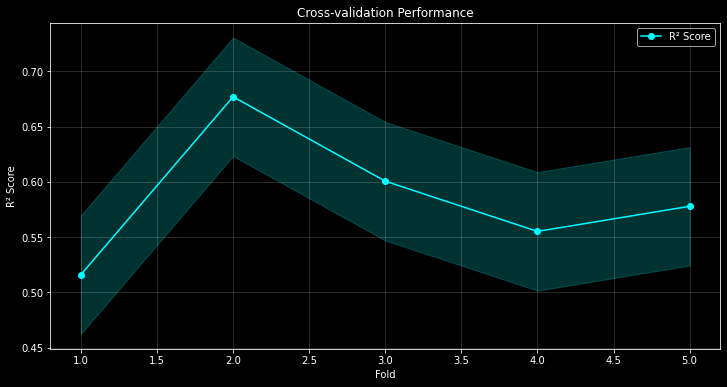

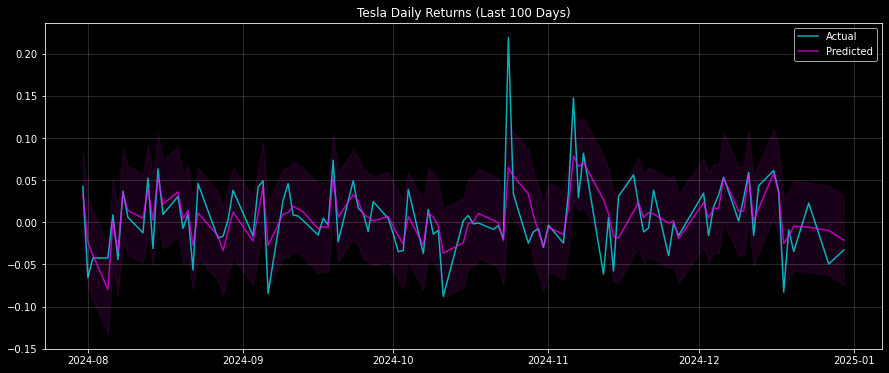

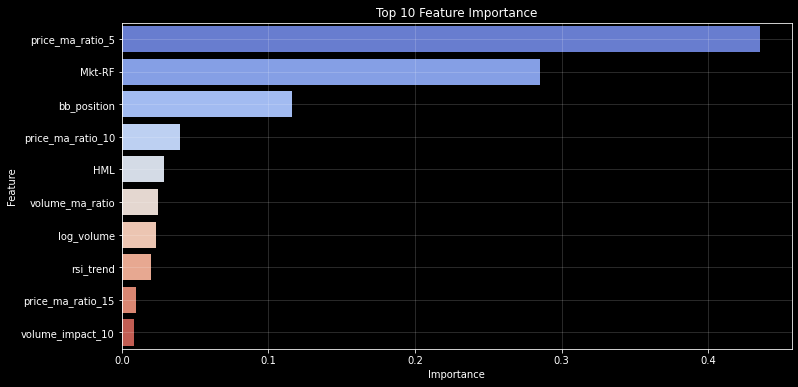


Directional Accuracy:
--------------------------------------------------
Prediction Accuracy: 0.7689


In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

def create_balanced_features(df):
    """Enhanced feature engineering with market emphasis"""
    
    # Market features
    df['market_volatility'] = df['Mkt-RF'].rolling(20).std()
    df['market_strength'] = df['Mkt-RF'].rolling(10).mean() / df['market_volatility']
    
    # Volume features
    df['log_volume'] = np.log1p(df['volume'])
    df['volume_ma_ratio'] = df['volume'] / df['volume'].rolling(20).mean()
    
    # Technical indicators with market context
    df['rsi_trend'] = df['RSI_15'].rolling(5).mean() / df['RSI_15'].rolling(20).mean()
    df['bb_position'] = (df['close'] - df['BBL_10_2.0']) / (df['BBU_10_2.0'] - df['BBL_10_2.0'])
    
    # Price action features
    for window in [5, 10, 15]:
        df[f'price_ma_ratio_{window}'] = df['close'] / df['close'].rolling(window).mean()
        df[f'volume_impact_{window}'] = (df['volume'] / df['volume'].rolling(window).mean()) * df['market_volatility']
    
    # Factor interactions
    df['quality_value'] = df['RMW'] * df['HML']
    df['size_momentum'] = df['SMB'] * df['market_strength']
    
    return df

# Load and prepare data
df = pd.read_csv('INFO6105_Final_TSLA_FeatureMart (1).xls')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Create balanced features
df = create_balanced_features(df)

# Select balanced feature set
selected_features = [
    'market_volatility', 'market_strength',
    'log_volume', 'volume_ma_ratio',
    'rsi_trend', 'bb_position',
    'price_ma_ratio_5', 'price_ma_ratio_10', 'price_ma_ratio_15',
    'volume_impact_5', 'volume_impact_10',
    'quality_value', 'size_momentum',
    'Mkt-RF', 'SMB', 'HML'
]

# Prepare features and target
y = df['Return_1D']
X = pd.DataFrame()

for feature in selected_features:
    if feature in df.columns:
        X[feature] = df[feature]

# Clean data
X = X.fillna(method='ffill').fillna(method='bfill')
mask = ~(X.isna().any(axis=1) | y.isna())
X = X[mask]
y = y[mask]

# Scale features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5, test_size=int(len(X)*0.15))
cv_scores = []
cv_rmse = []

# Model with balanced parameters
model = GradientBoostingRegressor(
    n_estimators=150,
    learning_rate=0.03,
    max_depth=2,
    subsample=0.6,
    min_samples_split=40,
    min_samples_leaf=30,
    max_features=0.6,
    random_state=42
)

# Enhanced cross-validation
print("\nCross-validation Results:")
print("-" * 50)
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_scaled), 1):
    X_tr, X_val = X_scaled.iloc[train_idx], X_scaled.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model.fit(X_tr, y_tr)
    val_pred = model.predict(X_val)
    
    fold_r2 = r2_score(y_val, val_pred)
    fold_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    
    cv_scores.append(fold_r2)
    cv_rmse.append(fold_rmse)
    
    print(f"Fold {fold}:")
    print(f"R² Score: {fold_r2:.4f}")
    print(f"RMSE: {fold_rmse:.4f}")
    print()

print("Cross-validation Summary:")
print(f"Mean R²: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")
print(f"Mean RMSE: {np.mean(cv_rmse):.4f} (±{np.std(cv_rmse):.4f})")

# Final evaluation
train_size = int(len(X_scaled) * 0.8)
X_train = X_scaled[:train_size]
X_test = X_scaled[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate metrics
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("\nFinal Model Metrics:")
print("-" * 50)
print(f"Training R²: {r2_train:.4f}")
print(f"Testing R²: {r2_test:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")

# Feature importance analysis
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print("-" * 50)
print(importance.head(10))

# Enhanced visualizations
plt.style.use('dark_background')

# 1. Cross-validation performance
plt.figure(figsize=(12, 6))
plt.plot(range(1, 6), cv_scores, marker='o', color='cyan', label='R² Score')
plt.fill_between(range(1, 6), 
                 np.array(cv_scores) - np.std(cv_scores),
                 np.array(cv_scores) + np.std(cv_scores),
                 alpha=0.2, color='cyan')
plt.title('Cross-validation Performance')
plt.xlabel('Fold')
plt.ylabel('R² Score')
plt.grid(True, alpha=0.2)
plt.legend()
plt.show()

# 2. Actual vs Predicted with confidence bands
plt.figure(figsize=(15, 6))
plt.plot(y_test.index[-100:], y_test[-100:], label='Actual', color='cyan', alpha=0.7)
plt.plot(y_test.index[-100:], y_pred_test[-100:], label='Predicted', color='magenta', alpha=0.7)
std_dev = np.std(y_test - y_pred_test)
plt.fill_between(y_test.index[-100:],
                 y_pred_test[-100:] - 2*std_dev,
                 y_pred_test[-100:] + 2*std_dev,
                 color='magenta', alpha=0.1)
plt.title('Tesla Daily Returns (Last 100 Days)')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

# 3. Feature importance plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance.head(10),
           palette='coolwarm')
plt.title('Top 10 Feature Importance')
plt.grid(True, alpha=0.2)
plt.show()

# Calculate directional accuracy
accuracy = np.mean(np.sign(y_pred_test) == np.sign(y_test))
print("\nDirectional Accuracy:")
print("-" * 50)
print(f"Prediction Accuracy: {accuracy:.4f}")
